In [1]:
import numpy as np
import pandas as pd 
import random as rd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


import warnings 
warnings.filterwarnings('ignore')

In [3]:
sales=pd.read_csv('sales_train.csv')

item_cat=pd.read_csv('item_categories.csv')

item=pd.read_csv('items.csv')

sample_sub=pd.read_csv('sample_submission.csv')

test=pd.read_csv('test.csv')

In [4]:
# Overview of the dataset:

print('Sales Data:')

print(sales.head())
print(sales.info())
print(sales.describe())
print(sales.columns)
print(sales.shape)


print('Test Data:')

print(test.head())
print(test.info())
print(test.describe())
print(test.columns)
print(test.shape)


print('Item Categories:')

print(item_cat.head())
print(item_cat.info())
print(item_cat.describe())
print(item_cat.columns)
print(item_cat.shape)

print('Item Categories:')

print(item_cat.head())
print(item_cat.info())
print(item_cat.describe())
print(item_cat.columns)
print(item_cat.shape)

print('Item:')

print(item.head())
print(item.info())
print(item.describe())
print(item.columns)
print(item.shape)

Sales Data:
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
       date_block_num       shop_id       item_id    item_price  item_cnt_day
count    2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06
mean     1.456991e+01  3.300173e+01  1.019723e+04  8.90853

In [5]:
#converting the datetime into date object

sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

In [6]:
monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

In [7]:

monthly_sales.reset_index(inplace = True)
print(monthly_sales.head())

  date_block_num shop_id item_id       date            item_price item_cnt_day
                                        min        max       mean          sum
0              0       0      32 2013-01-03 2013-01-31      221.0          6.0
1              0       0      33 2013-01-03 2013-01-28      347.0          3.0
2              0       0      35 2013-01-31 2013-01-31      247.0          1.0
3              0       0      43 2013-01-31 2013-01-31      221.0          1.0
4              0       0      51 2013-01-13 2013-01-31      128.5          2.0


## Graphs:

Text(0, 0.5, 'total sales')

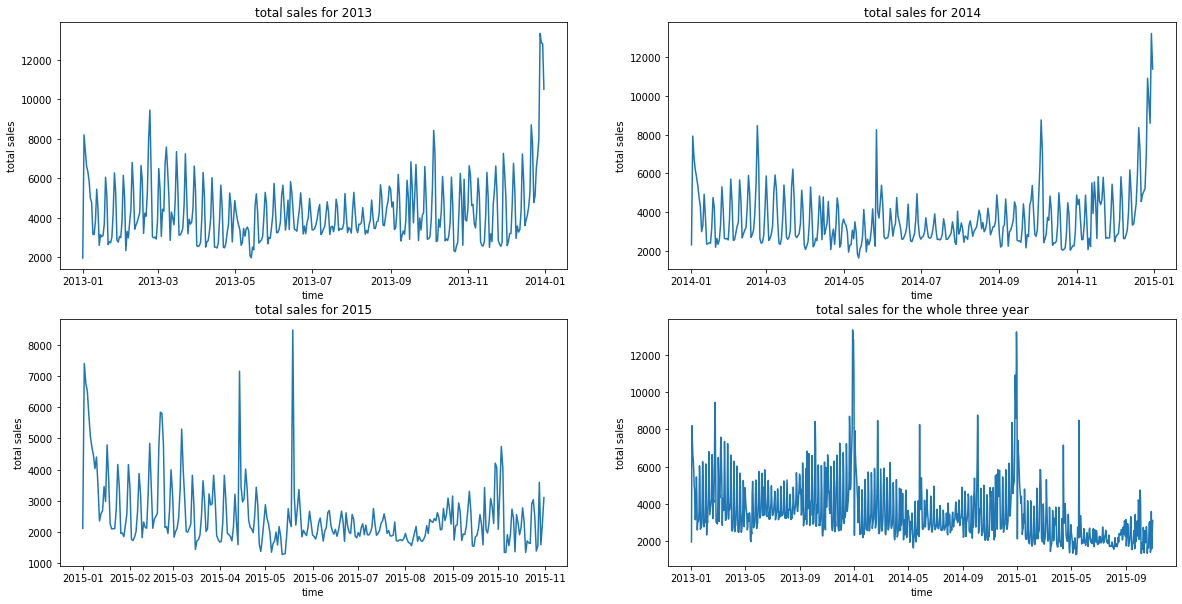

In [8]:
total_sales=sales.groupby(['date'])['item_cnt_day'].sum()

total_sales.astype('float')

f,axes=plt.subplots(2,2, figsize=(20,10))

ts_2013=total_sales[:365]
ts_2014=total_sales[365:730]
ts_2015=total_sales[730:]

axes[0,0].plot(ts_2013)
axes[0,0].set_title('total sales for 2013')
axes[0,0].set_xlabel('time')
axes[0,0].set_ylabel('total sales')

axes[0,1].plot(ts_2014)
axes[0,1].set_title('total sales for 2014')
axes[0,1].set_xlabel('time')
axes[0,1].set_ylabel('total sales')

axes[1,0].plot(ts_2015)
axes[1,0].set_title('total sales for 2015')
axes[1,0].set_xlabel('time')
axes[1,0].set_ylabel('total sales')

axes[1,1].plot(total_sales)
axes[1,1].set_title('total sales for the whole three year')
axes[1,1].set_xlabel('time')
axes[1,1].set_ylabel('total sales')



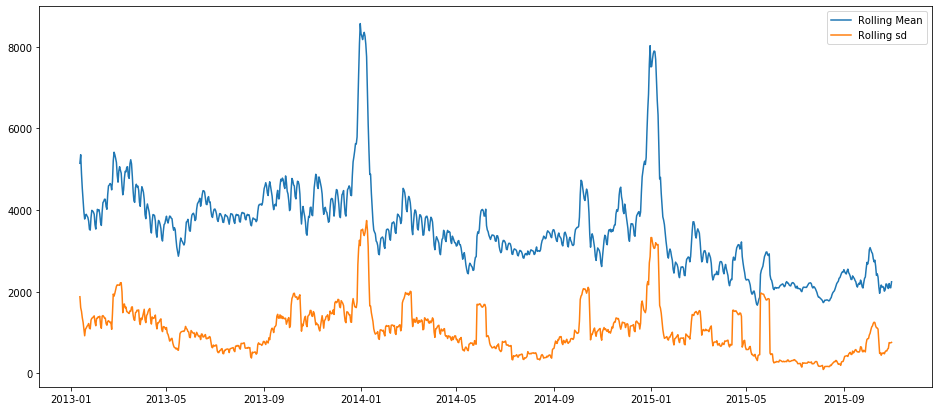

In [9]:
plt.figure(figsize=(16,7))
MM=total_sales.rolling(window=12, center=False).mean()
MSD=total_sales.rolling(window=12, center=False).std()

plt.plot(MM, label='Rolling Mean')
plt.plot(MSD, label='Rolling sd')
plt.legend()

Per the graph, the data shows an obvious "seasonality" especially during the winter. Therefore, we will look into the Trend, seasonality and residuals.

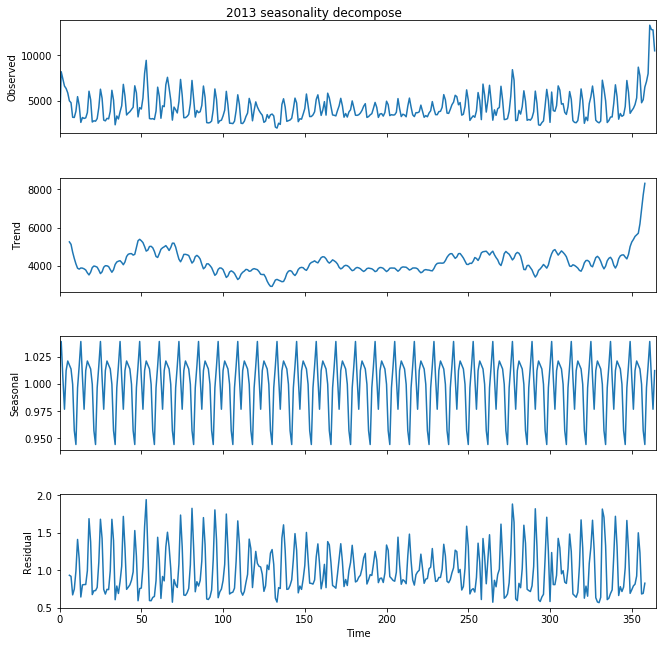

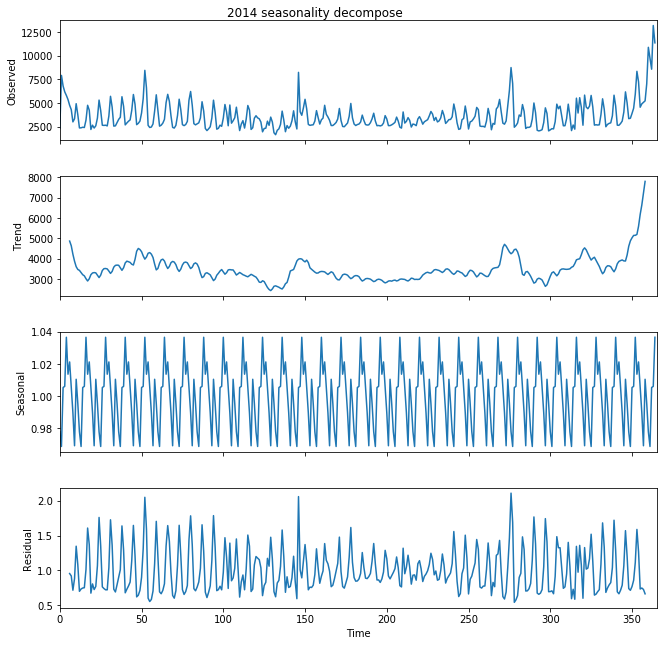

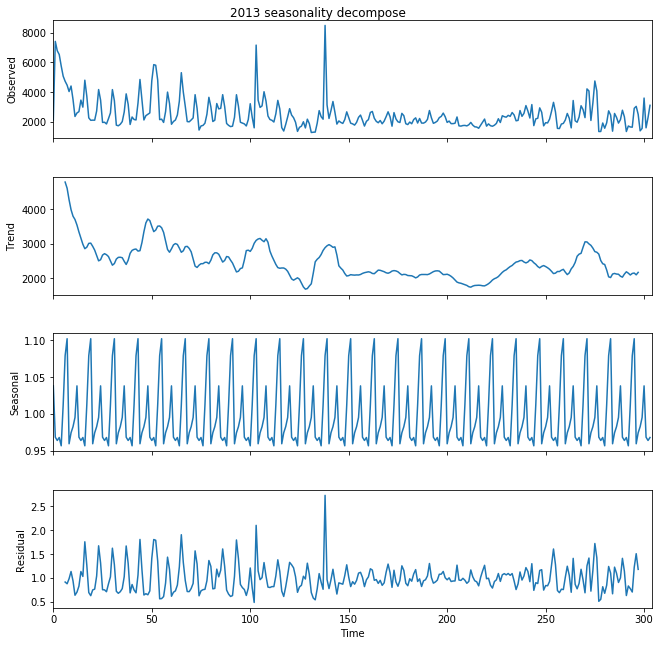

In [10]:
#seasonality:

import statsmodels.api as sm

# use either multiplicative and additive model:
#2013:

decom_mul=sm.tsa.seasonal_decompose(ts_2013.values, freq=12, model='multiplicative')


fig=decom_mul.plot()
fig.suptitle('2013 seasonality decompose')
fig.set_figheight(10)
fig.set_figwidth(10)

#2014:
decom_mul=sm.tsa.seasonal_decompose(ts_2014.values, freq=12, model='multiplicative')

fig=decom_mul.plot()
fig.suptitle('2014 seasonality decompose')
fig.set_figheight(10)
fig.set_figwidth(10)


decom_mul=sm.tsa.seasonal_decompose(ts_2015.values, freq=12, model='multiplicative')

fig=decom_mul.plot()
fig.suptitle('2013 seasonality decompose')
fig.set_figheight(10)
fig.set_figwidth(10)

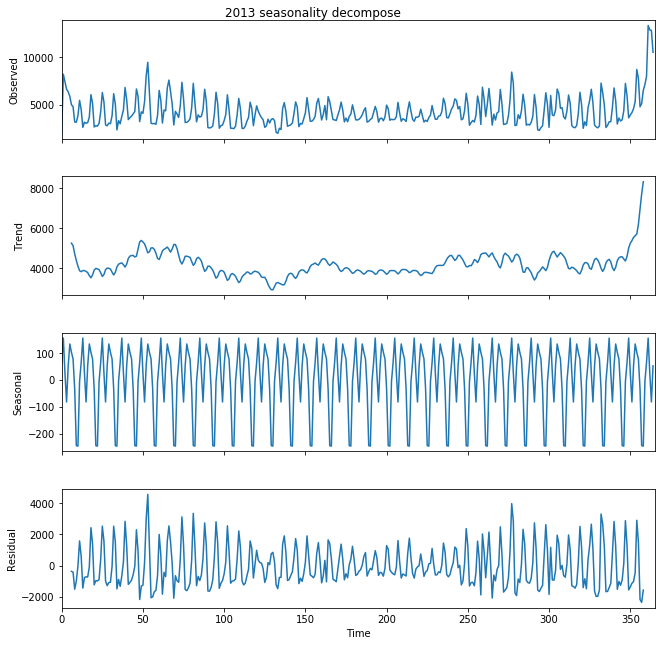

In [11]:
#additive model:

decom_add=sm.tsa.seasonal_decompose(ts_2013.values, freq=12, model='additive')

fig_add=decom_add.plot()

fig_add.suptitle('2013 seasonality decompose')
fig_add.set_figheight(10)
fig_add.set_figwidth(10)


In [12]:
#absolutely seasonality exists from these charts


In [13]:
# AR, MA and ARMA models:

#Pure AR Models - Depends on the lagged values of the data you are modeling to make forecasts

#Pure MA Models - Depends on the errors(residuals) of the previous forecasts you made to make current forecasts



In [14]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)  #time series axies
        acf_ax = plt.subplot2grid(layout, (1, 0))   #autocorrelation
        pacf_ax = plt.subplot2grid(layout, (1, 1))  #partial autocorrelation
    
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        plt.tight_layout()
        
    return 

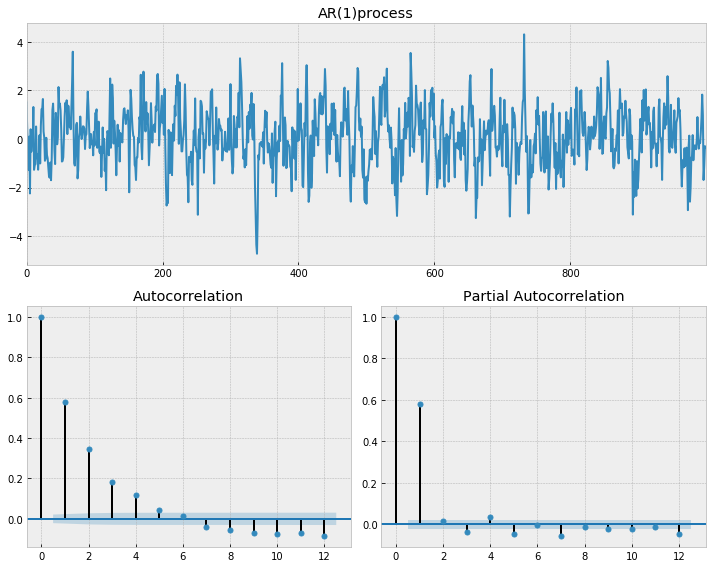

In [15]:
#Simulate an AR(1) process w/ alpha =0.6

np.random.seed(1)
n_samples=int(1000)
a=0.6
x=w=np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t]=a*x[t-1]+w[t]

lags=12

_=tsplot(x, lags=lags,title="AR(1)process")

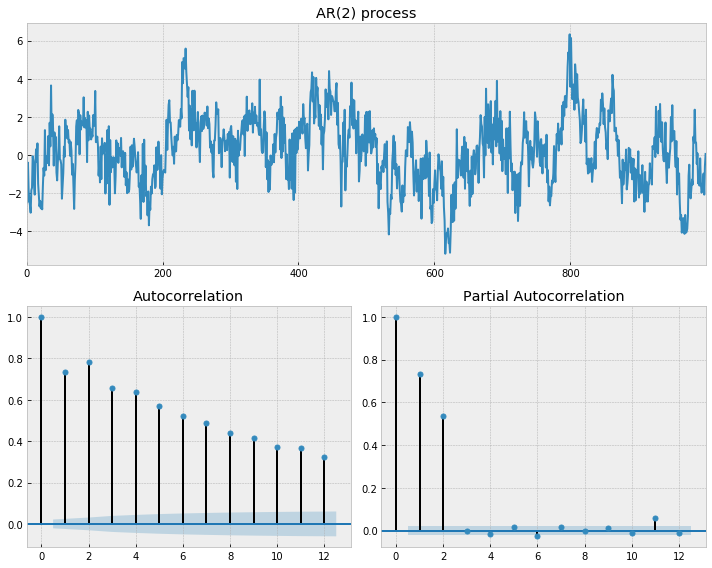

In [16]:
#Simulate an AR(2):

n=int(1000)
alphas=np.array([0.33,0.55])
betas=np.array([0.])


AR=np.r_[1,-alphas]
MA=np.r_[1-betas]

AR2=smt.arma_generate_sample(ar=AR, ma=MA, nsample=n)
_=tsplot(AR2, lags=12,title="AR(2) process")

In [17]:
#AR(1) process -- has ACF tailing out and PACF cutting off at lag=1
#AR(2) process -- has ACF tailing out and PACF cutting off at lag=2

#For an AR model, the theoretical PACF “shuts off” past the order of the model. 
#The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. 
#Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. 

## MA

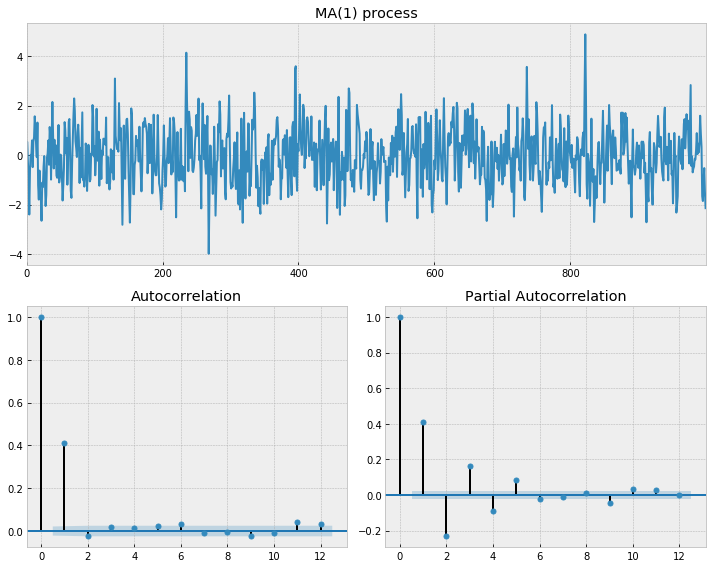

In [18]:
#simulate MA(1) process:

n=int(1000)

alphas=np.array([0.])
betas=np.array([0.6])

AR=np.r_[1,-alphas]
MA=np.r_[1,betas]
MA1=smt.arma_generate_sample(ar=AR, ma=MA, nsample=n)
lags=12
_=tsplot(MA1,lags=lags, title="MA(1) process")


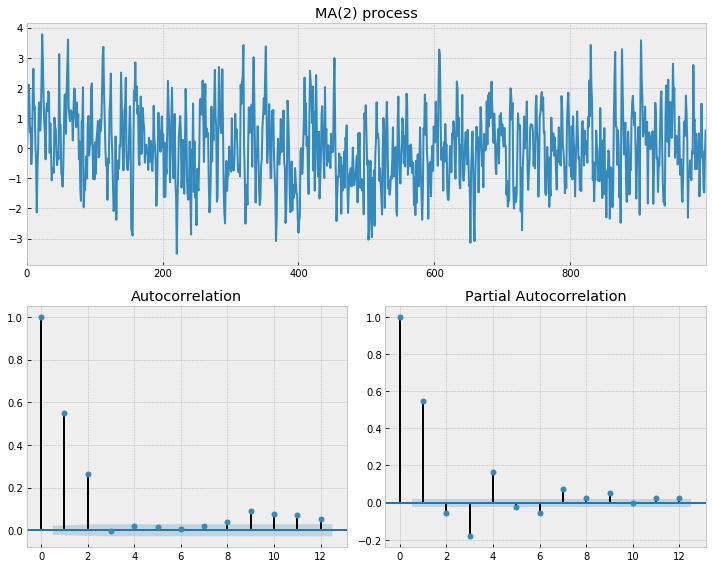

In [19]:
#simulate an MA(2) process:

n=int(1000)
alphas=np.array([0.])
betas=np.array([0.6,0.4])
AR=np.r_[1,-alphas]
MA=np.r_[1,betas]

MA3=smt.arma_generate_sample(ar=AR, ma=MA, nsample=n)
_=tsplot(MA3, lags=lags, title='MA(2) process')

In [20]:
#MA(1) process -- has ACF cut off at lag=1
#MA(2) process -- has ACF cut off at lag=2

## Machine learning LSTM

In [50]:
#import libraries:

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.models import Sequential, Model
from keras.utils import plot_model
from keras.layers.convolutional import Conv1D, MaxPooling1D

from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout


In [ ]:
# merge test dataset:

dataset = sales.pivot_table(index = ['shop_id','item_id'],values = ['item_cnt_day'],columns = ['date_block_num'],fill_value = 0,aggfunc='sum')
dataset.reset_index(inplace=True)

In [22]:
dataset.head()

shop_id item_id item_cnt_day                        ...        \
date_block_num                            0   1  2  3  4  5  6  7  ... 24 25   
0                    0      30            0  31  0  0  0  0  0  0  ...  0  0   
1                    0      31            0  11  0  0  0  0  0  0  ...  0  0   
2                    0      32            6  10  0  0  0  0  0  0  ...  0  0   
3                    0      33            3   3  0  0  0  0  0  0  ...  0  0   
4                    0      35            1  14  0  0  0  0  0  0  ...  0  0   

                                        
date_block_num 26 27 28 29 30 31 32 33  
0               0  0  0  0  0  0  0  0  
1               0  0  0  0  0  0  0  0  
2               0  0  0  0  0  0  0  0  
3               0  0  0  0  0  0  0  0  
4               0  0  0  0  0  0  0  0  

[5 rows x 36 columns]

In [23]:
#prepare the dataset:

dataset=pd.merge(test, dataset, on=['item_id','shop_id'], how='left')
dataset.head()

,ID,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
#dataset.drop([,'ID','shop_id', "item_id"],inplace=True, axis=1)
dataset.head()


,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
# get the train dataset:

Xtrain=np.expand_dims(dataset.values[:,:-1], axis=2)
ytrain=dataset.values[:,-1:]

X_train, X_valid, y_train, y_valid=train_test_split(Xtrain, ytrain, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape) #[samples, timesteps, features]

(128520, 33, 1)
(85680, 33, 1)


In [34]:
# get the test dataset:
Xtest=np.expand_dims(dataset.values[:,1:],axis=2)
Xtest.shape

(214200, 33, 1)

In [53]:
#LSTM:

model_LSTM=Sequential()
model_LSTM.add(LSTM(units=70, input_shape=(X_train.shape[1], X_train.shape[2])))
model_LSTM.add(Dropout(0.4))
model_LSTM.add(Dense(1))
               
model_LSTM.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
model_LSTM.summary()               

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 70)                20160     
_________________________________________________________________
dropout_1 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 71        
Total params: 20,231
Trainable params: 20,231
Non-trainable params: 0
_________________________________________________________________


In [54]:
history_lstm = model_LSTM.fit(X_train,y_train,batch_size = 4000,epochs = 12)



Epoch 1/12
128520/128520 [==============================] - 50s 391us/step - loss: nan - mean_squared_error: nan
Epoch 2/12
128520/128520 [==============================] - 50s 391us/step - loss: nan - mean_squared_error: nan
Epoch 3/12
128520/128520 [==============================] - 50s 390us/step - loss: nan - mean_squared_error: nan
Epoch 4/12
128520/128520 [==============================] - 48s 372us/step - loss: nan - mean_squared_error: nan
Epoch 5/12
128520/128520 [==============================] - 48s 373us/step - loss: nan - mean_squared_error: nan
Epoch 6/12
128520/128520 [==============================] - 48s 372us/step - loss: nan - mean_squared_error: nan
Epoch 7/12
128520/128520 [==============================] - 48s 371us/step - loss: nan - mean_squared_error: nan
Epoch 8/12
128520/128520 [==============================] - 48s 372us/step - loss: nan - mean_squared_error: nan
Epoch 9/12
128520/128520 [==============================] - 48s 371us/step - loss: nan - mean_s

In [56]:
#CNN:

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer='adam', metrics = ['mean_squared_error'])
model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 32, 64)            192       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                51250     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 51,493
Trainable params: 51,493
Non-trainable params: 0
_________________________________________________________________


In [57]:
history_cnn = model_cnn.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=12, verbose=2)

Train on 128520 samples, validate on 85680 samples
Epoch 1/12
 - 29s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 2/12
 - 29s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 3/12
 - 29s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 4/12
 - 29s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 5/12
 - 29s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 6/12
 - 29s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 7/12
 - 29s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 8/12
 - 29s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 9/12
 - 29s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 10/12
 - 29s - loss: nan 

In [87]:
# CNN-LSTM model:

# data preprocessing: [samples, subseq, timesteps, features]

subseq=3
timesteps=X_train.shape[1]//subseq
X_train_sub = X_train.reshape((X_train.shape[0], subseq, timesteps, 1))

X_valid_sub = X_valid.reshape((X_valid.shape[0], subseq, timesteps, 1))

print('Train set shape', X_train_sub.shape)
print('Validation set shape', X_valid_sub.shape)

Train set shape (128520, 3, 11, 1)
Validation set shape (85680, 3, 11, 1)


In [93]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_sub.shape[2], X_train_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer='adam')

In [91]:
historycnn_lstm = model_cnn_lstm.fit(X_train_sub, y_train, validation_data=(X_valid_sub, y_valid), epochs=12, verbose=2)

Train on 128520 samples, validate on 85680 samples
Epoch 1/12
 - 60s - loss: nan - val_loss: nan
Epoch 2/12
 - 58s - loss: nan - val_loss: nan
Epoch 3/12
 - 56s - loss: nan - val_loss: nan
Epoch 4/12
 - 57s - loss: nan - val_loss: nan
Epoch 5/12
 - 57s - loss: nan - val_loss: nan
Epoch 6/12
 - 56s - loss: nan - val_loss: nan
Epoch 7/12
 - 56s - loss: nan - val_loss: nan
Epoch 8/12
 - 56s - loss: nan - val_loss: nan
Epoch 9/12
 - 56s - loss: nan - val_loss: nan
Epoch 10/12
 - 56s - loss: nan - val_loss: nan
Epoch 11/12
 - 56s - loss: nan - val_loss: nan
Epoch 12/12
 - 57s - loss: nan - val_loss: nan


(128520, 33, 1)

33.0